<h1><center>  Classify foliar Diseases in Sorghum leaf</center></h1>

In [5]:
The main objective of the competition is to develop machine learning-based models to accurately classify a given leaf image from the test dataset to a particular disease category, and to identify an individual disease from multiple disease symptoms on a single leaf image.


SyntaxError: invalid syntax (<ipython-input-5-5deb1c6e58a5>, line 1)

## libraries 

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import random
import albumentations as A
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

# 2. About Dataset

In [6]:
train_image_path = '../input/plant-pathology-2021-fgvc8/train_images'
test_image_path = '../input/plant-pathology-2021-fgvc8/test_images'
train_df_path = '../input/plant-pathology-2021-fgvc8/train.csv'
test_df_path = '../input/plant-pathology-2021-fgvc8/sample_submission.csv'

> 📌**Note**:
* `train.csv` contains information about the image files available in `train_images`. It contains 18632 rows(images) with 2 columns i.e (image , labels )
* `test.csv` The test set images. This competition has a hidden test set: only three images are provided here as samples while the remaining 5,000 images will be available to your notebook once it is submitted.

In [7]:
df_train = pd.read_csv(train_df_path)
df_test=pd.read_csv(test_df_path)

In [8]:
df_test

image   labels
0  85f8cb619c66b863.jpg  healthy
1  ad8770db05586b59.jpg  healthy
2  c7b03e718489f3ca.jpg  healthy

In [9]:
df_train.labels.value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

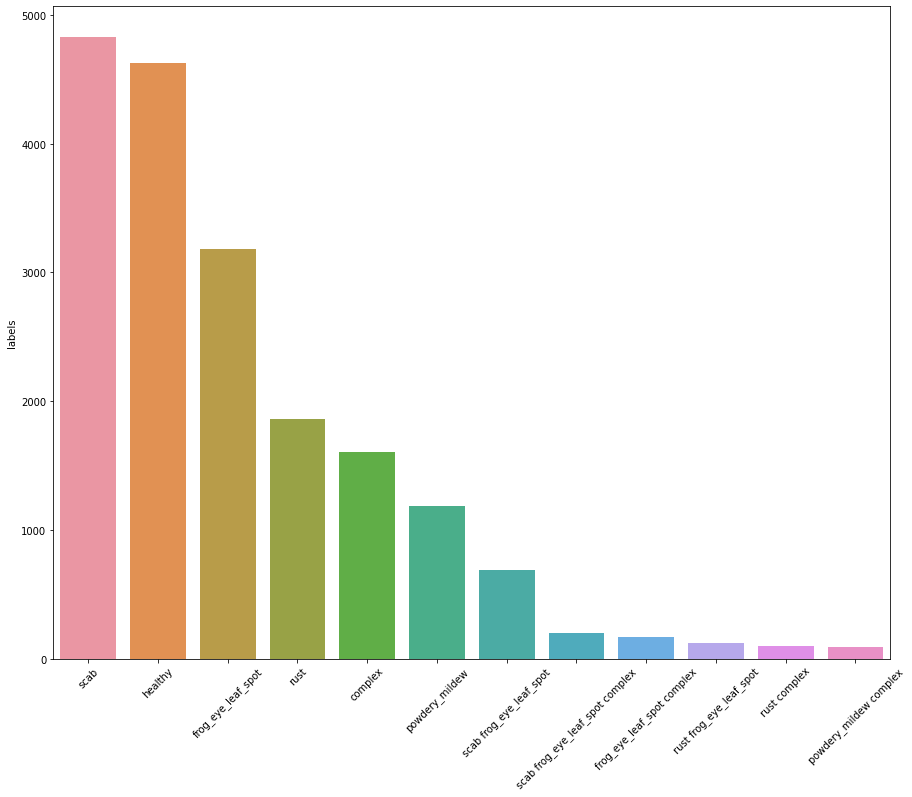

In [10]:
plt.figure(figsize=(15,12))
labels = sns.barplot(df_train.labels.value_counts().index,df_train.labels.value_counts())
for item in labels.get_xticklabels():
    item.set_rotation(45)

> 📌**Note**:
* We have multiple labels for eg. label can be **scab** or **scab and rust**
* Main labels are - **scab** , **healthy** , **frog_eye_leaf_spot** , **rust** , **complex** and **powdery_mildew**

## Batch Visualisation of Images 

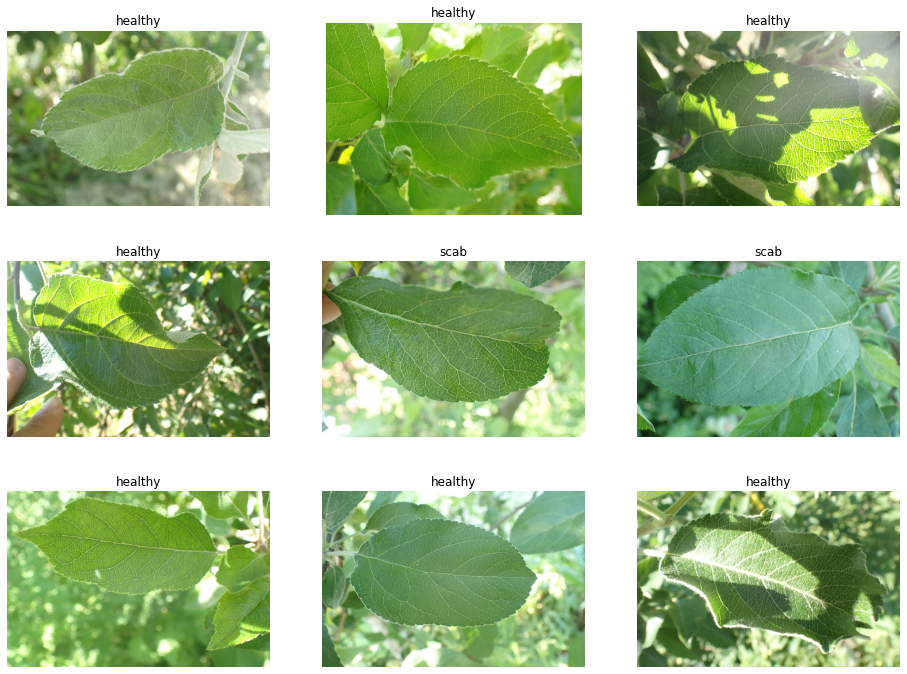

In [11]:
def batch_visualize(df,batch_size,path):
    sample_df = df_train.sample(9)
    image_names = sample_df["image"].values
    labels = sample_df["labels"].values
    plt.figure(figsize=(16, 12))
    
    for image_ind, (image_name, label) in enumerate(zip(image_names, labels)):
        plt.subplot(3, 3, image_ind + 1)
        image = cv2.imread(os.path.join(path, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    plt.show()
    
batch_visualize(df_train,9,train_image_path)

## Batch visualisation with labels

In [12]:
def batch_visualize_with_label(df,batch_size,path,label): 
    sample_df = df_train[df_train["labels"]==label].sample(9)
    image_names = sample_df["image"].values
    labels = sample_df["labels"].values
    plt.figure(figsize=(16, 12))
    
    for image_ind, (image_name, label) in enumerate(zip(image_names, labels)):
        plt.subplot(3, 3, image_ind + 1)
        image = cv2.imread(os.path.join(path, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

### Visualise healthy leaves

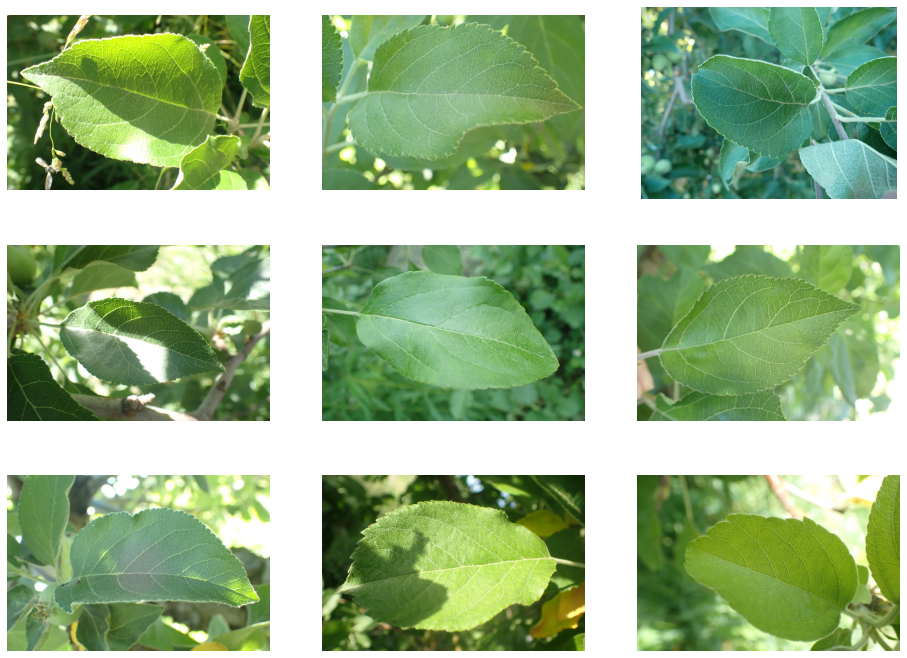

In [13]:
batch_visualize_with_label(df_train,9,train_image_path,'healthy')

### Visualise scab leaves 

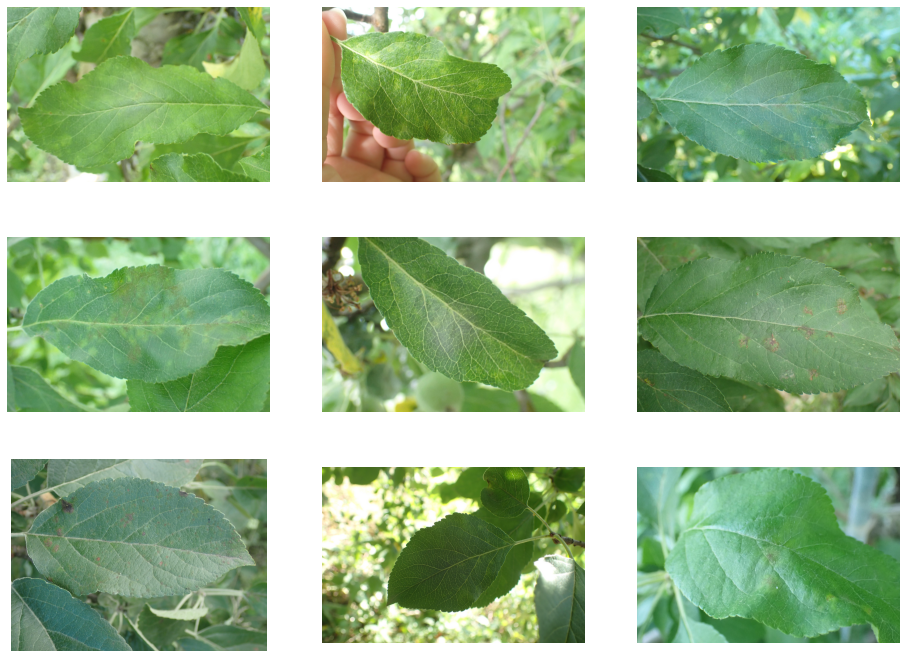

In [14]:
batch_visualize_with_label(df_train,9,train_image_path,'scab')

### Visualise frog_eye_leaf_spot  leaves

In [15]:
batch_visualize_with_label(df_train,9,train_image_path,'frog_eye_leaf_spot')

### Visualise rust leaves 

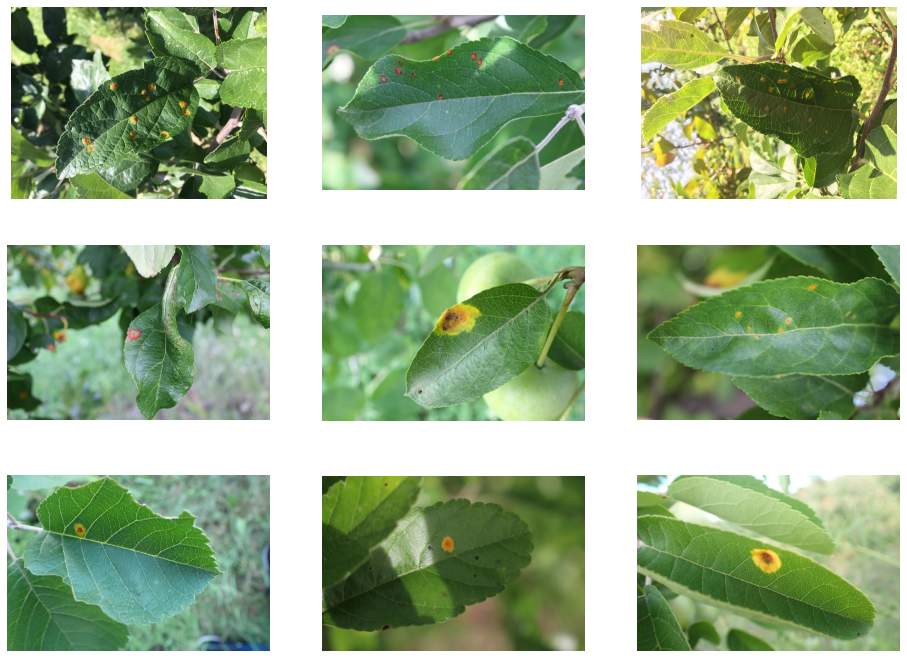

In [16]:
batch_visualize_with_label(df_train,9,train_image_path,'rust')

### Visualise complex leaves

In [17]:
batch_visualize_with_label(df_train,9,train_image_path,'complex')

### Visualise powdery_mildew leaves

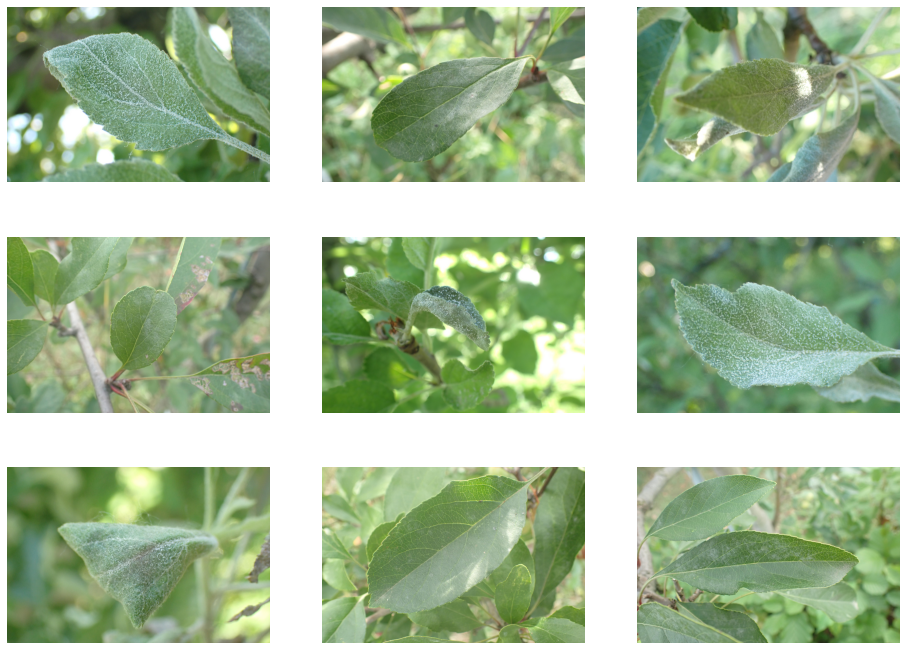

In [18]:
batch_visualize_with_label(df_train,9,train_image_path,'powdery_mildew')

# 3. Tensorflow Dataset Generation

In [19]:
HEIGHT = 128
WIDTH=128
SEED = 45
BATCH_SIZE= 64

train_datagen = ImageDataGenerator(rescale = 1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split = 0.2,
    zoom_range = 0.2,
    shear_range = 0.2,
    vertical_flip = False)

train_dataset = train_datagen.flow_from_dataframe(
    df_train,
    directory = train_image_path,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "training",
    shuffle = True,
    seed = SEED,
    validate_filenames = False
)


validation_dataset = train_datagen.flow_from_dataframe(
    df_train,
    directory = train_image_path,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "validation",
    shuffle = True,
    seed = SEED,
    validate_filenames = False
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)
INPUT_SIZE = (HEIGHT,WIDTH,3)
test_dataset=test_datagen.flow_from_dataframe(
    df_test,
    directory=test_image_path,
    x_col='image',
    y_col=None,
    class_mode=None,
    target_size=INPUT_SIZE[:2]
)


Found 14906 non-validated image filenames belonging to 12 classes.
Found 3726 non-validated image filenames belonging to 12 classes.
Found 3 validated image filenames.


> Refer Tensorflow docs for more information [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

# 4. Convolutional Neural Networks 

In [20]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(HEIGHT,WIDTH,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(12,activation='softmax'))

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       7

In [22]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
model_history=model.fit_generator(train_dataset,
                                  validation_data=validation_dataset,
                                  epochs=5,
                                  steps_per_epoch=train_dataset.samples//128,
                                 validation_steps=validation_dataset.samples//128,
                                 callbacks=[cp_callback]
                                 )

Epoch 1/5
 26/116 [=====>........................] - ETA: 13:07 - loss: 2.1676 - accuracy: 0.2169

# Prediction

In [ ]:
train_dataset.class_indices.items()

In [ ]:
preds = model.predict(test_dataset)
print(preds)

In [ ]:
preds_disease_ind=np.argmax(preds, axis=-1)

In [ ]:
preds_disease_ind